# Problem Set 5: Optic Flow
---
## Setup

In [1]:
# IPython magic
%load_ext autoreload
%autoreload 2
# Matplotlib magic
%matplotlib inline

In [143]:
# Imports
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
# Matplotlib params
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
## Hide axes in plots
show_axis = True
plt.rcParams['xtick.bottom'] = show_axis
plt.rcParams['xtick.labelbottom'] = show_axis
plt.rcParams['ytick.left'] = show_axis
plt.rcParams['ytick.labelleft'] = show_axis
plt.rcParams['axes.spines.left'] = show_axis
plt.rcParams['axes.spines.bottom'] = show_axis
plt.rcParams['axes.spines.top'] = show_axis
plt.rcParams['axes.spines.right'] = show_axis
## Axis labels
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelpad'] = 8

---
## 1. Gaussian and Laplacian Pyramids
### 1.1 Reduce

In [144]:
yos1 = cv2.imread('images/DataSeq1/yos_img_01.jpg', cv2.IMREAD_GRAYSCALE)
yos1 = yos1.astype(np.float) / 255
print(yos1.shape)

(252, 316)


In [145]:
def reduce(img):
    # Reduction filter
    w = np.array([1, 4, 6, 4, 1]) / 16
    # Apply filter and only take odd indices
    img_red = cv2.sepFilter2D(img, -1, w, w)[::2, ::2]
    return img_red

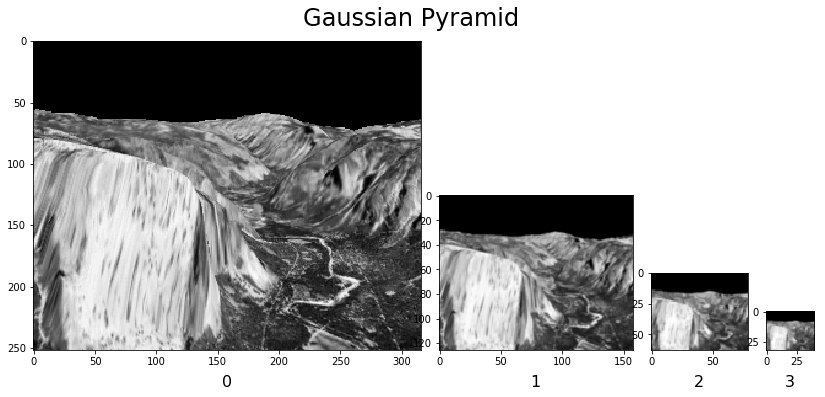

In [158]:
num_levels = 4
fig = plt.figure()
fig.suptitle('Gaussian Pyramid', y=0.72)
gs = gridspec.GridSpec(1, num_levels, width_ratios=[2**i for i in range(num_levels)][::-1], wspace=0.1)
g = yos1
for i in range(num_levels):
    ax = plt.subplot(gs[i])
    ax.imshow(g)
    ax.set_anchor('S')
    ax.set_xlabel(i, fontsize=16)
    g = reduce(g)

### 1.2 Expand

In [147]:
def expand(img, dstsize=None):
    '''
    ref: https://docs.opencv.org/2.4.13.7/doc/tutorials/imgproc/pyramids/pyramids.html
    '''
    # Expansion filter
    w = 2 * np.array([1, 4, 6, 4, 1]) / 16
    if dstsize is None:
        # Double size
        img_exp = np.zeros((2*img.shape[0], 2*img.shape[1]))
    else:
        # Use given size
        img_exp = np.zeros(dstsize)
    # Odd indices
    img_exp[::2, ::2] = img
    # Apply filter
    img_exp = cv2.sepFilter2D(img_exp, -1, w, w)
    return img_exp

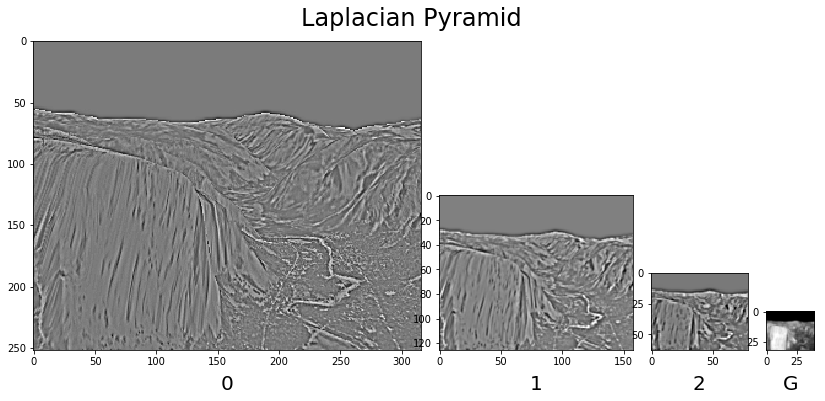

In [148]:
num_levels = 4
fig = plt.figure()
fig.suptitle('Laplacian Pyramid', y=0.72)
gs = gridspec.GridSpec(1, num_levels, width_ratios=[2**i for i in range(num_levels)][::-1], wspace=0.1)
g = yos1
for i in range(num_levels-1):
    l = g - expand(reduce(g), dstsize=g.shape)
    ax = plt.subplot(gs[i])
    ax.imshow(l)
    ax.set_anchor('S')
    ax.set_xlabel(i, fontsize=16)
    g = reduce(g)
ax = plt.subplot(gs[-1])
ax.imshow(g)
ax.set_anchor('S')
ax.set_xlabel('G', fontsize=16);

---
## 2. Lucas Kanade optic flow

In [601]:
img1_u8 = cv2.imread('images/TestSeq/Shift0.png', cv2.IMREAD_GRAYSCALE)
img1 = img1_u8.astype(np.float) / 255

In [602]:
def gradX(img):
    '''
    Calculate horizontal image gradient.
    '''
    # Horizonal Sobel
    grad_img = cv2.Sobel(img, -1, 1, 0,ksize=1)
    return grad_img
    
def gradY(img):
    '''
    Calculate vertical image gradient.
    '''
    # Vertical Sobel
    grad_img = cv2.Sobel(img, -1, 0, 1,ksize=1)
    return grad_img

### 2.1 Small Displacements

In [603]:
def plot_flow_quiver(img, u, v, resolution=5):
    plt.imshow(img1)
    m, n = img.shape
    x = range(0, n, resolution)
    y = range(0, m, resolution)
    xv, yv = np.meshgrid(x, y)
    u_ = u[yv, xv]
    # Positive v corresponds to movement in negative y
    v_ = -v[yv, xv]
    plt.quiver(xv, yv, u_, v_, color='r')
    return

def plot_flow_dense(u, v):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    flowmin = min(u.min(), v.min())
    flowmax = max(u.max(), v.max())
    ## Horizontal
    im1 = ax1.imshow(u, vmin=flowmin, vmax=flowmax)
    ax1.set_title('Horizontal flow (u)')
    ax1.axis('off')
    ## Vertical
    im2 = ax2.imshow(v, vmin=flowmin, vmax=flowmax)
    ax2.set_title('Vertical flow (v)')
    ax2.axis('off')
    fig.tight_layout()
    return

In [628]:
def lk_single(img1, img2, blursize=1, window_size=3):
    # Blur
    img1 = cv2.GaussianBlur(img1, (blursize, blursize), 0)
    img2 = cv2.GaussianBlur(img2, (blursize, blursize), 0)
    # Gradients
    Ix = gradX(img1)
    Iy = gradY(img1)
    # Time derivative
    It = img2 - img1
    # 2nd Order Moments
    IxIx = cv2.boxFilter(Ix*Ix, -1, ksize=(window_size, window_size))
    IxIy = cv2.boxFilter(Ix*Iy, -1, ksize=(window_size, window_size))
    IyIy = cv2.boxFilter(Iy*Iy, -1, ksize=(window_size, window_size))
    IxIt = cv2.boxFilter(Ix*It, -1, ksize=(window_size, window_size))
    IyIt = cv2.boxFilter(Iy*It, -1, ksize=(window_size, window_size))
    # Initialize outputs
    u = np.zeros(img1.shape)
    v = np.zeros(img1.shape)
    for y, x in np.ndindex(img1.shape):
        A = np.array([[IxIx[y,x], IxIy[y,x]],
                      [IxIy[y,x], IyIy[y,x]]])
        b = np.array([-IxIt[y,x], -IyIt[y,x]])
        u[y,x], v[y,x] = np.linalg.solve(A, b)
    return u, v

#### a. ShiftR2

In [636]:
img2_u8 = cv2.imread('images/TestSeq/ShiftR2.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

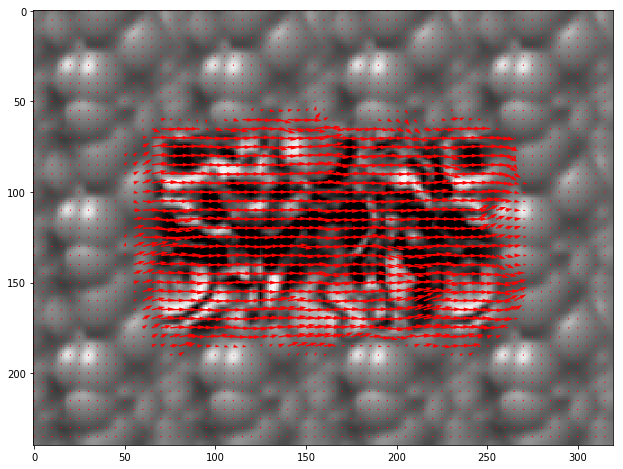

In [637]:
u, v = lk_single(img1, img2, blursize=21, window_size=21)
plot_flow_quiver(img1, u, v)

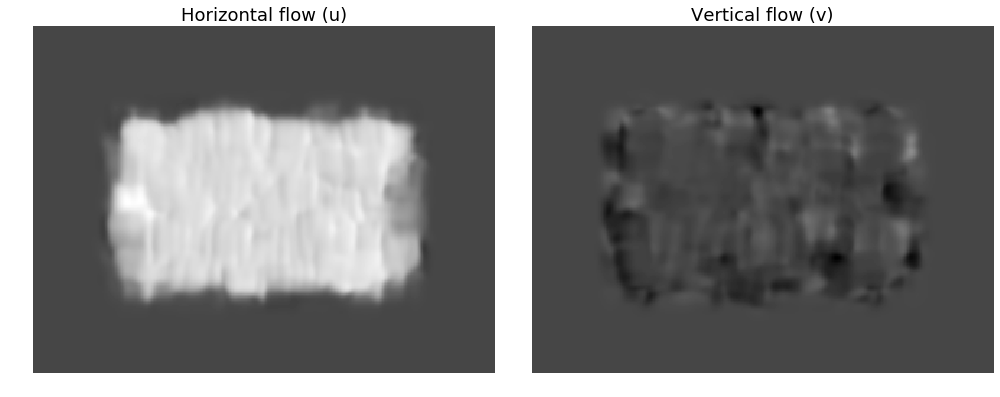

In [638]:
plot_flow_dense(u,v)

#### b. ShiftR5U5

In [639]:
img2_u8 = cv2.imread('images/TestSeq/ShiftR5U5.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

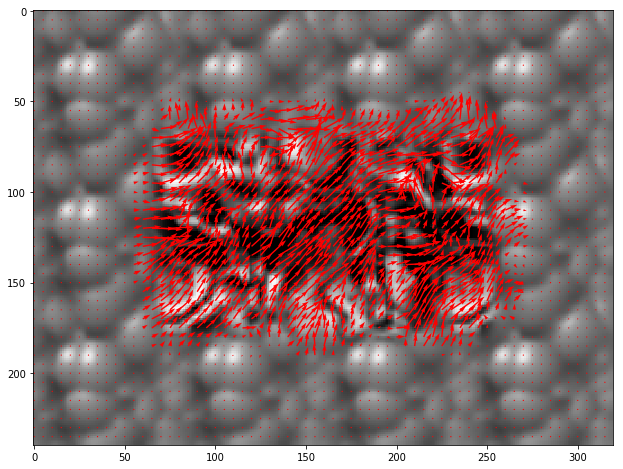

In [640]:
u, v = lk_single(img1, img2, blursize=21, window_size=21)
plot_flow_quiver(img1, u, v)

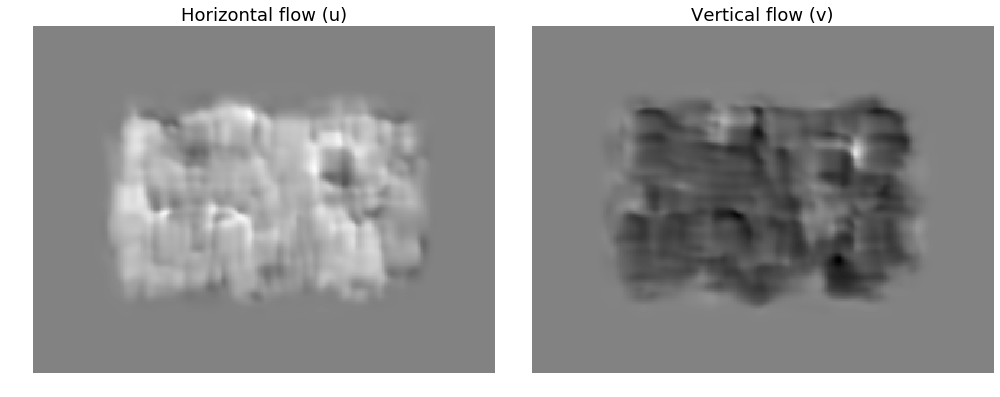

In [641]:
plot_flow_dense(u,v)

### 2.2 Large Displacements

#### a. ShiftR10

In [642]:
img2_u8 = cv2.imread('images/TestSeq/ShiftR10.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

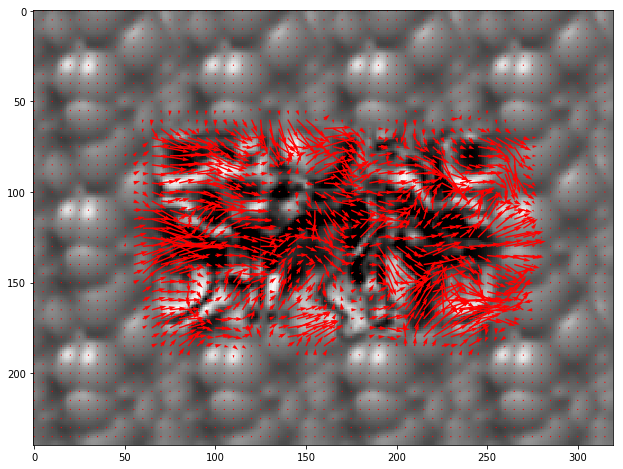

In [643]:
u, v = lk_single(img1, img2, blursize=21, window_size=21)
plot_flow_quiver(img1, u, v)

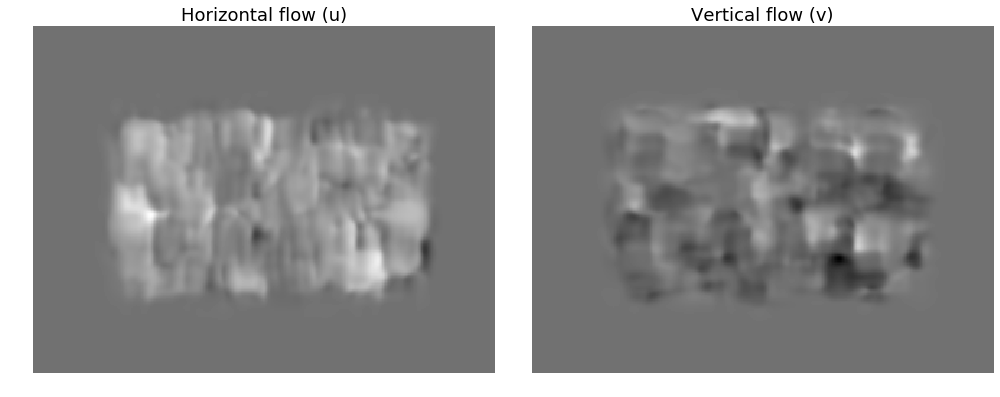

In [644]:
plot_flow_dense(u,v)

#### b. ShiftR20

In [649]:
img2_u8 = cv2.imread('images/TestSeq/ShiftR20.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

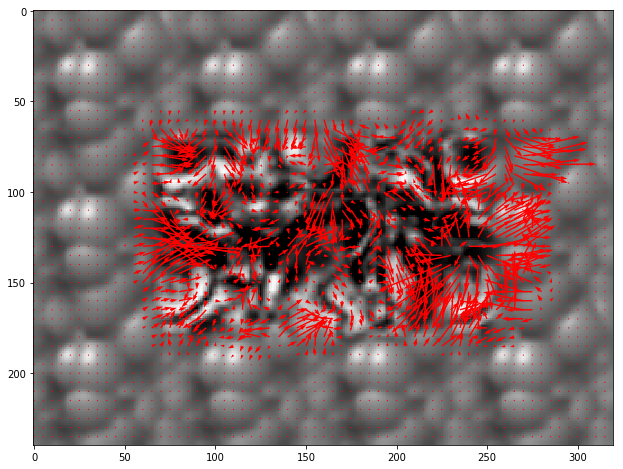

In [650]:
u, v = lk_single(img1, img2, blursize=21, window_size=21)
plot_flow_quiver(img1, u, v)

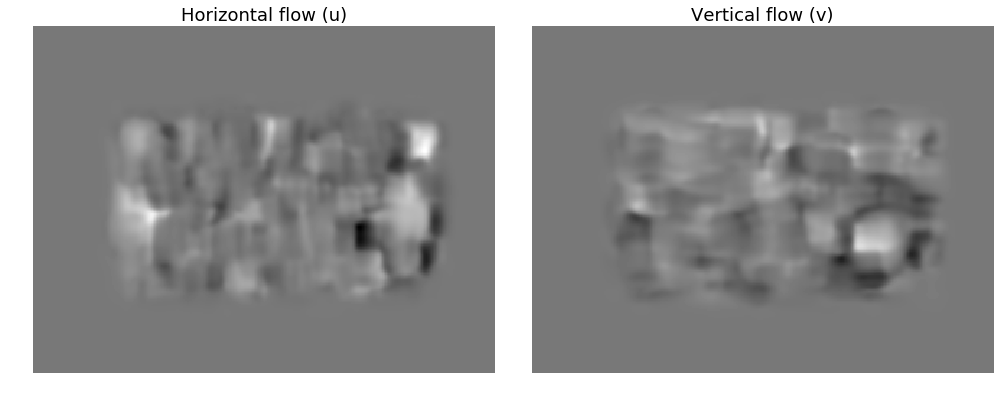

In [651]:
plot_flow_dense(u,v)

#### c. ShiftR40

In [652]:
img2_u8 = cv2.imread('images/TestSeq/ShiftR40.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

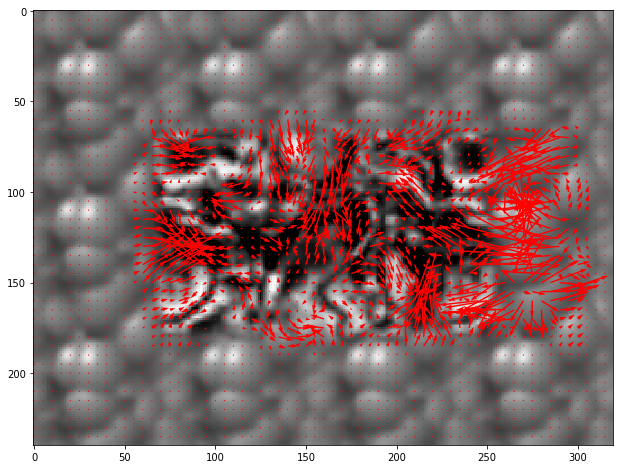

In [653]:
u, v = lk_single(img1, img2, blursize=21, window_size=21)
plot_flow_quiver(img1, u, v)

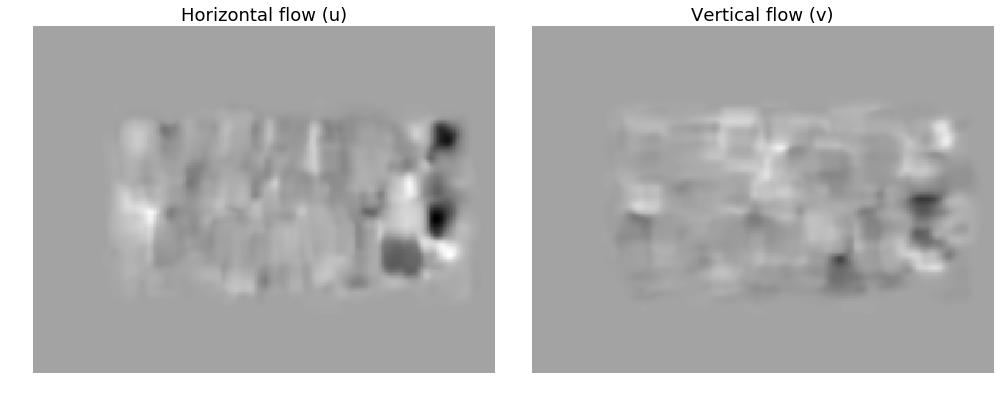

In [654]:
plot_flow_dense(u,v)

### 2.3 Warping

# Rough

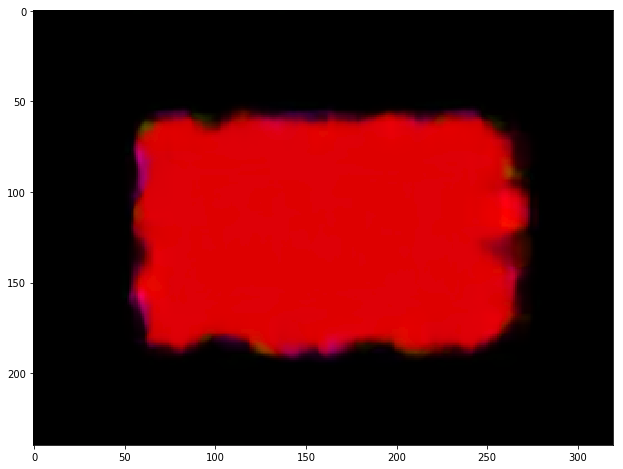

In [646]:
hsv = np.zeros(img1_u8.shape + (3,))
hsv[...,1] = 255

flow = cv2.calcOpticalFlowFarneback(img1_u8, img2_u8, None, 0.5, 3, 15, 3, 5, 1.2, 0)
mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
hsv[...,0] = ang*180/np.pi/2
hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
hsv = hsv.astype('uint8')
rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
plt.imshow(rgb)

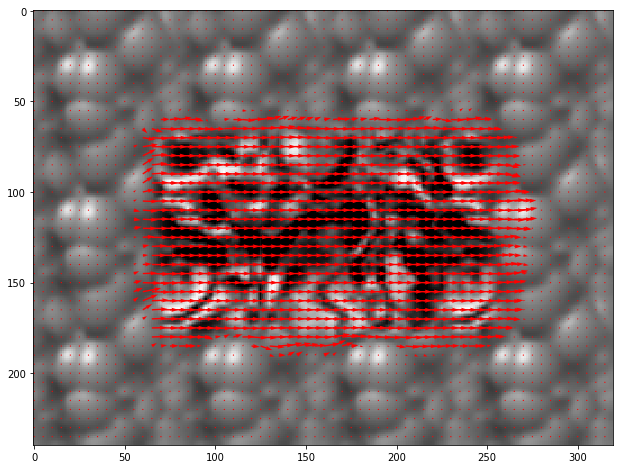

In [647]:
u, v = flow[:, :, 0], flow[:, :, 1]
plot_flow_quiver(img1, u, v, resolution=5)

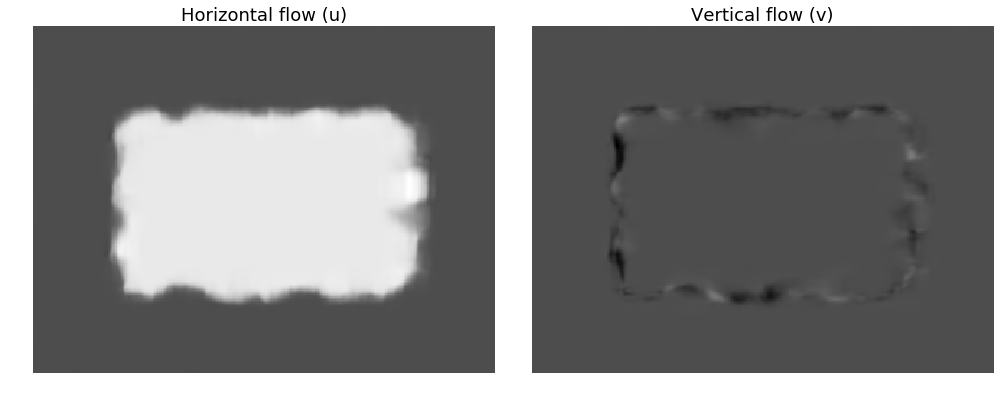

In [648]:
plot_flow_dense(u, v)

### 2.2 Expand

### 2.3 Expand

---
## 3. Hierarchical LK optic flow

---
## 4. The Juggle Sequence

---
## 5. The Taxi Sequence

---
# ROUGH

In [187]:
# Gradients
Ix = gradX(img1b, normalize=True)
Iy = gradY(img1b, normalize=True)
# Window size
k = 5
# 2nd Order Moments
# IxIx = cv2.GaussianBlur(Ix*Ix, (k, k), 0)
# IxIy = cv2.GaussianBlur(Ix*Iy, (k, k), 0)
# IyIy = cv2.GaussianBlur(Iy*Iy, (k, k), 0)
IxIx = cv2.boxFilter(Ix*Ix, -1, ksize=(k, k), normalize=False)
IxIy = cv2.boxFilter(Ix*Iy, -1, ksize=(k, k), normalize=False)
IyIy = cv2.boxFilter(Iy*Iy, -1, ksize=(k, k), normalize=False)
# Time derivative
# k = 3
# It = cv2.boxFilter(img2, -1, ksize=(k, k)) - cv2.boxFilter(img1, -1, ksize=(k, k))
It = img2 - img1
# IxIt = cv2.GaussianBlur(Ix*It, (k, k), 0)
# IyIt = cv2.GaussianBlur(Iy*It, (k, k), 0)
k = 5
IxIt = cv2.boxFilter(Ix*It, -1, ksize=(k, k), normalize=False)
IyIt = cv2.boxFilter(Iy*It, -1, ksize=(k, k), normalize=False)
u = np.zeros(img1.shape)
v = np.zeros(img1.shape)
for y, x in np.ndindex(img1.shape):
    A = np.array([[IxIx[y,x], IxIy[y,x]],
                  [IxIy[y,x], IyIy[y,x]]])
    b = np.array([-IxIt[y,x], -IyIt[y,x]])
    if np.linalg.matrix_rank(A, tol=0.01) == 2:
        u[y,x], v[y,x] = np.linalg.solve(A, b)